мысли





# Либы

In [ ]:
import os
from google.colab import drive
import pandas as pd
import numpy as np
import tqdm
import gc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNetCV
from sklearn import  ensemble
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Распаковка train

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! unzip /content/drive/MyDrive/train.zip -d train

Archive:  /content/drive/MyDrive/train.zip
replace train/.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
file_list_train = []

for dirname, _, filenames in os.walk('/content/train'):
    for filename in filenames:
        file_list_train.append(os.path.join(dirname, filename))

In [ ]:
len(file_list_train)

4432

In [ ]:
file_list_train[0]

'/content/train/1964262681.csv'

In [ ]:
time_file = pd.read_csv("/content/drive/MyDrive/train.csv")

In [ ]:
time_file

,segment_id,time_to_eruption
0,1136037770,12262005
1,1969647810,32739612
2,1895879680,14965999
3,2068207140,26469720
4,192955606,31072429
...,...,...
4426,873340274,15695097
4427,1297437712,35659379
4428,694853998,31206935
4429,1886987043,9598270


# Распаковка Test

In [ ]:
! unzip /content/drive/MyDrive/test.zip -d test

In [ ]:
file_list_test = []

for dirname, _, filenames in os.walk('/content/test'):
    for filename in filenames:
        file_list_test.append(os.path.join(dirname, filename))

In [ ]:
len(file_list_test)

4520

# Анализ train
(было бы славно не трогать эти ячейки)

4432 датасета для каждого вулкана,

по 60001 строчке в каждом
где-то есть Nan, где то нет

данные слабо коррелирую между собой



In [ ]:
df=pd.read_csv(file_list_train[8])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60001 entries, 0 to 60000
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   sensor_1   60001 non-null  bool 
 1   sensor_2   60001 non-null  bool 
 2   sensor_3   60001 non-null  bool 
 3   sensor_4   60001 non-null  bool 
 4   sensor_5   60001 non-null  bool 
 5   sensor_6   60001 non-null  bool 
 6   sensor_7   60001 non-null  bool 
 7   sensor_8   60001 non-null  bool 
 8   sensor_9   60001 non-null  bool 
 9   sensor_10  60001 non-null  bool 
dtypes: bool(10)
memory usage: 586.1 KB


In [ ]:
keys = list(pd.read_csv(file_list_train[0]).keys())
nanC = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
for index in range(len(file_list_train)):
    df = pd.read_csv(file_list_train[index])
    for key in df.keys():
        if df[key].isna().sum() == len(pd.read_csv(file_list_train[0])):
            nanC[keys.index(key)] += 1

print(nanC)
data={'sensors': keys, 'count': nanC}
NaNDF = pd.DataFrame(data)
print(NaNDF)

[24, 835, 435, 0, 595, 0, 42, 440, 124, 24]
     sensors  count
0   sensor_1     24
1   sensor_2    835
2   sensor_3    435
3   sensor_4      0
4   sensor_5    595
5   sensor_6      0
6   sensor_7     42
7   sensor_8    440
8   sensor_9    124
9  sensor_10     24


<Axes: xlabel='sensors'>

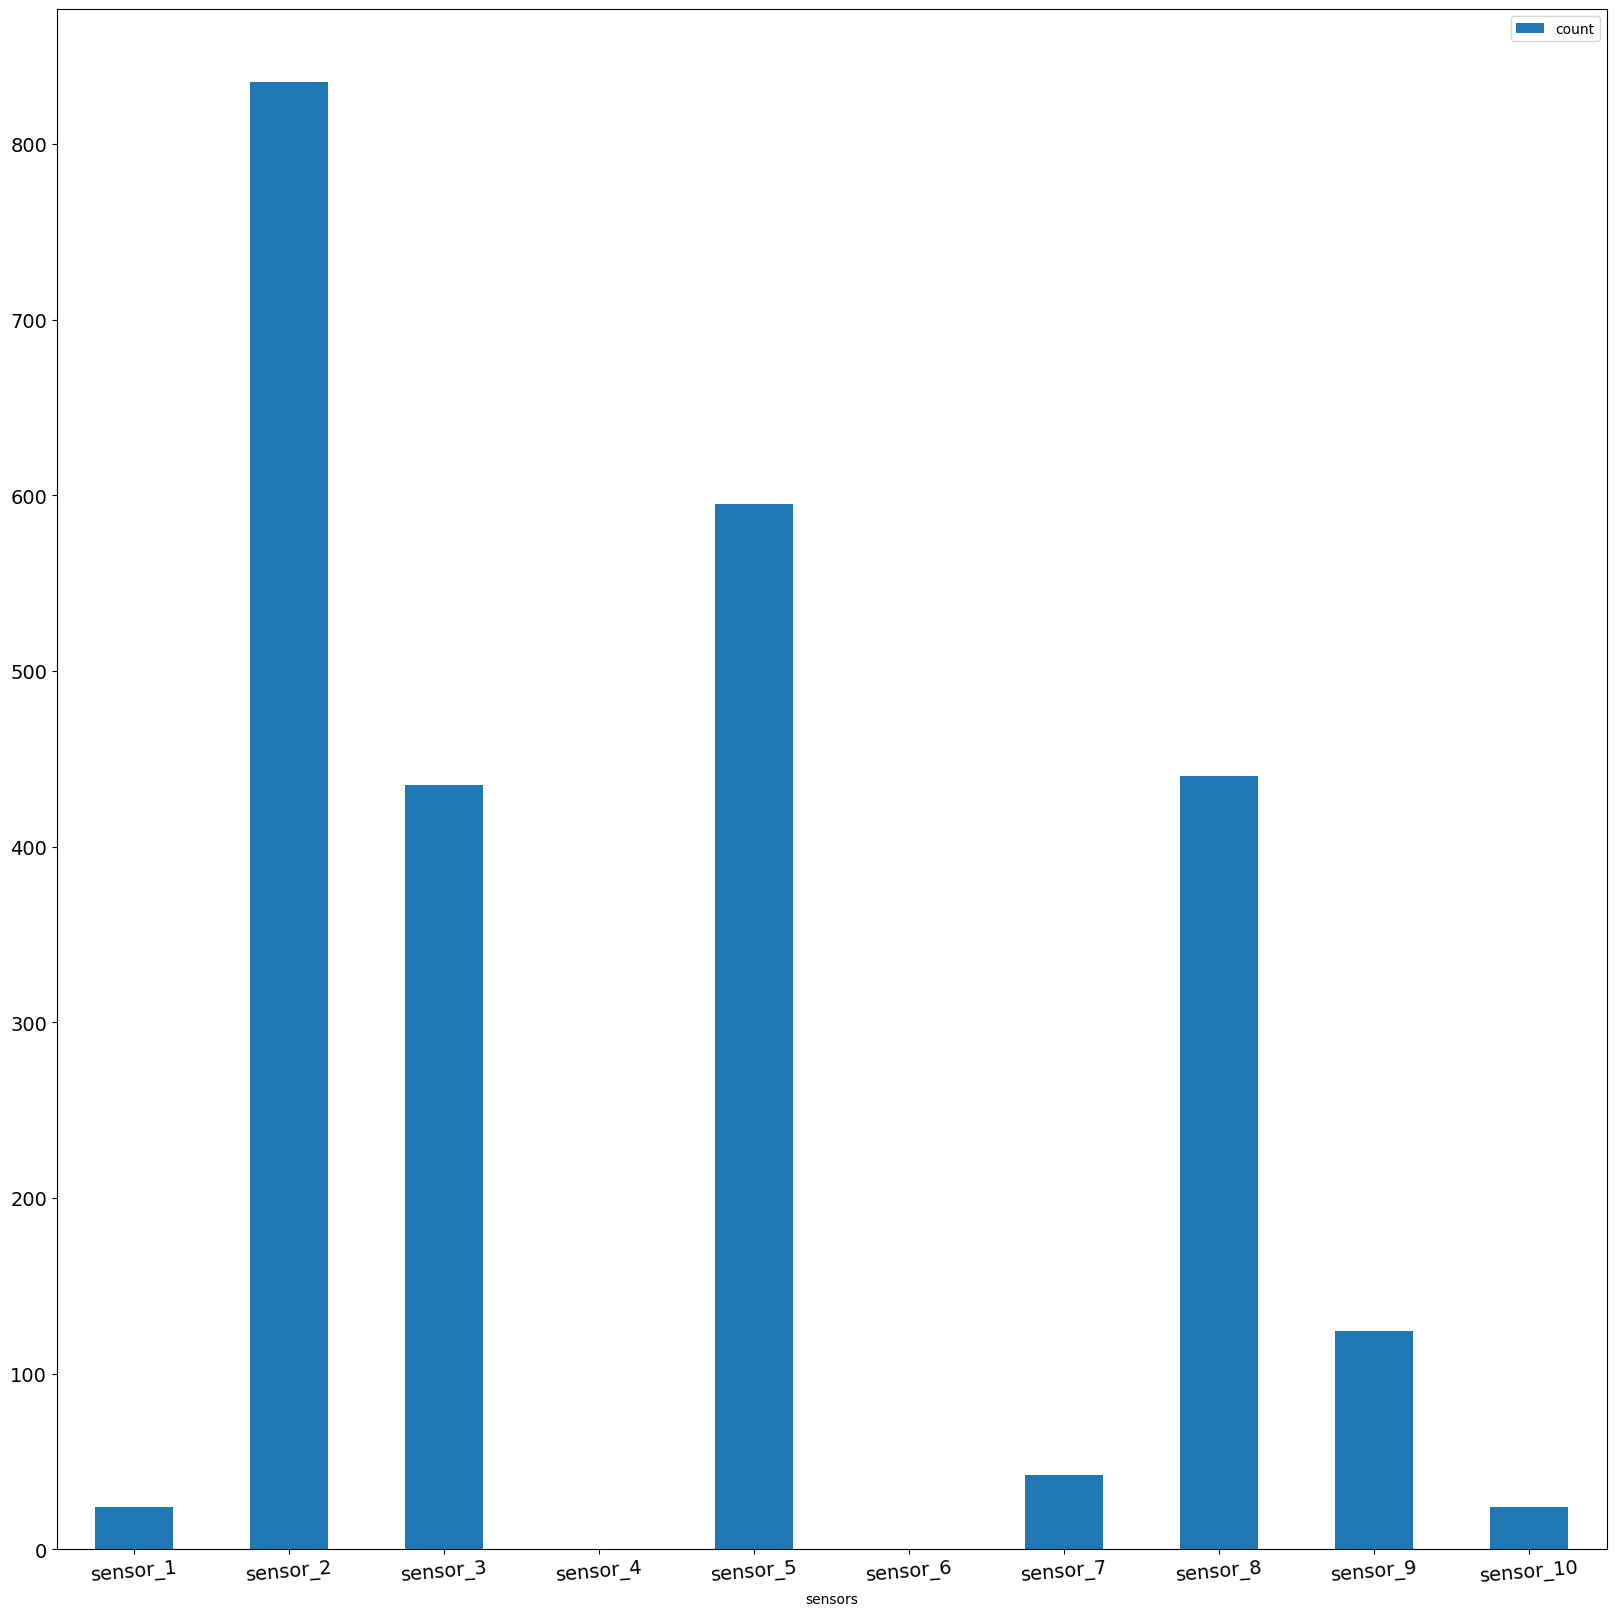

In [ ]:
NaNDF.plot(figsize =(20, 20), x="sensors", y="count", kind="bar",  rot=5, fontsize=14 )

In [ ]:
df=df.dropna()

# Визуализация(train)
(было бы славно не трогать эти ячейки)

<Axes: >

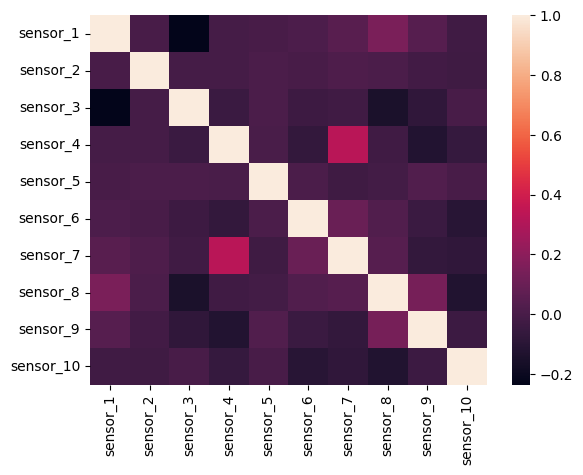

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(df.corr())

<ipython-input-51-4e749fa0ee63>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(time_file['time_to_eruption'],


<Axes: xlabel='time_to_eruption', ylabel='Density'>

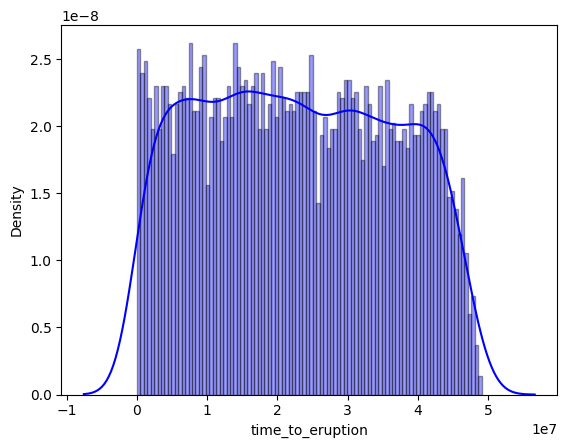

In [ ]:
sns.distplot(time_file['time_to_eruption'],
            hist=True,
            kde=True,
            bins=100,
            color='blue',
            hist_kws={'edgecolor':'black'})

# Анализ test

In [ ]:
keys = list(pd.read_csv(file_list_test[0]).keys())
nanC = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
for index in range(len(file_list_test)):
    df = pd.read_csv(file_list_test[index])
    for key in df.keys():
        if df[key].isna().sum() == len(pd.read_csv(file_list_test[0])):
            nanC[keys.index(key)] += 1

print(nanC)
data={'sensors': keys, 'count': nanC}
NaNDF = pd.DataFrame(data)
print(NaNDF)

[387, 1257, 434, 0, 1388, 0, 34, 294, 817, 760]
     sensors  count
0   sensor_1    387
1   sensor_2   1257
2   sensor_3    434
3   sensor_4      0
4   sensor_5   1388
5   sensor_6      0
6   sensor_7     34
7   sensor_8    294
8   sensor_9    817
9  sensor_10    760


<Axes: xlabel='sensors'>

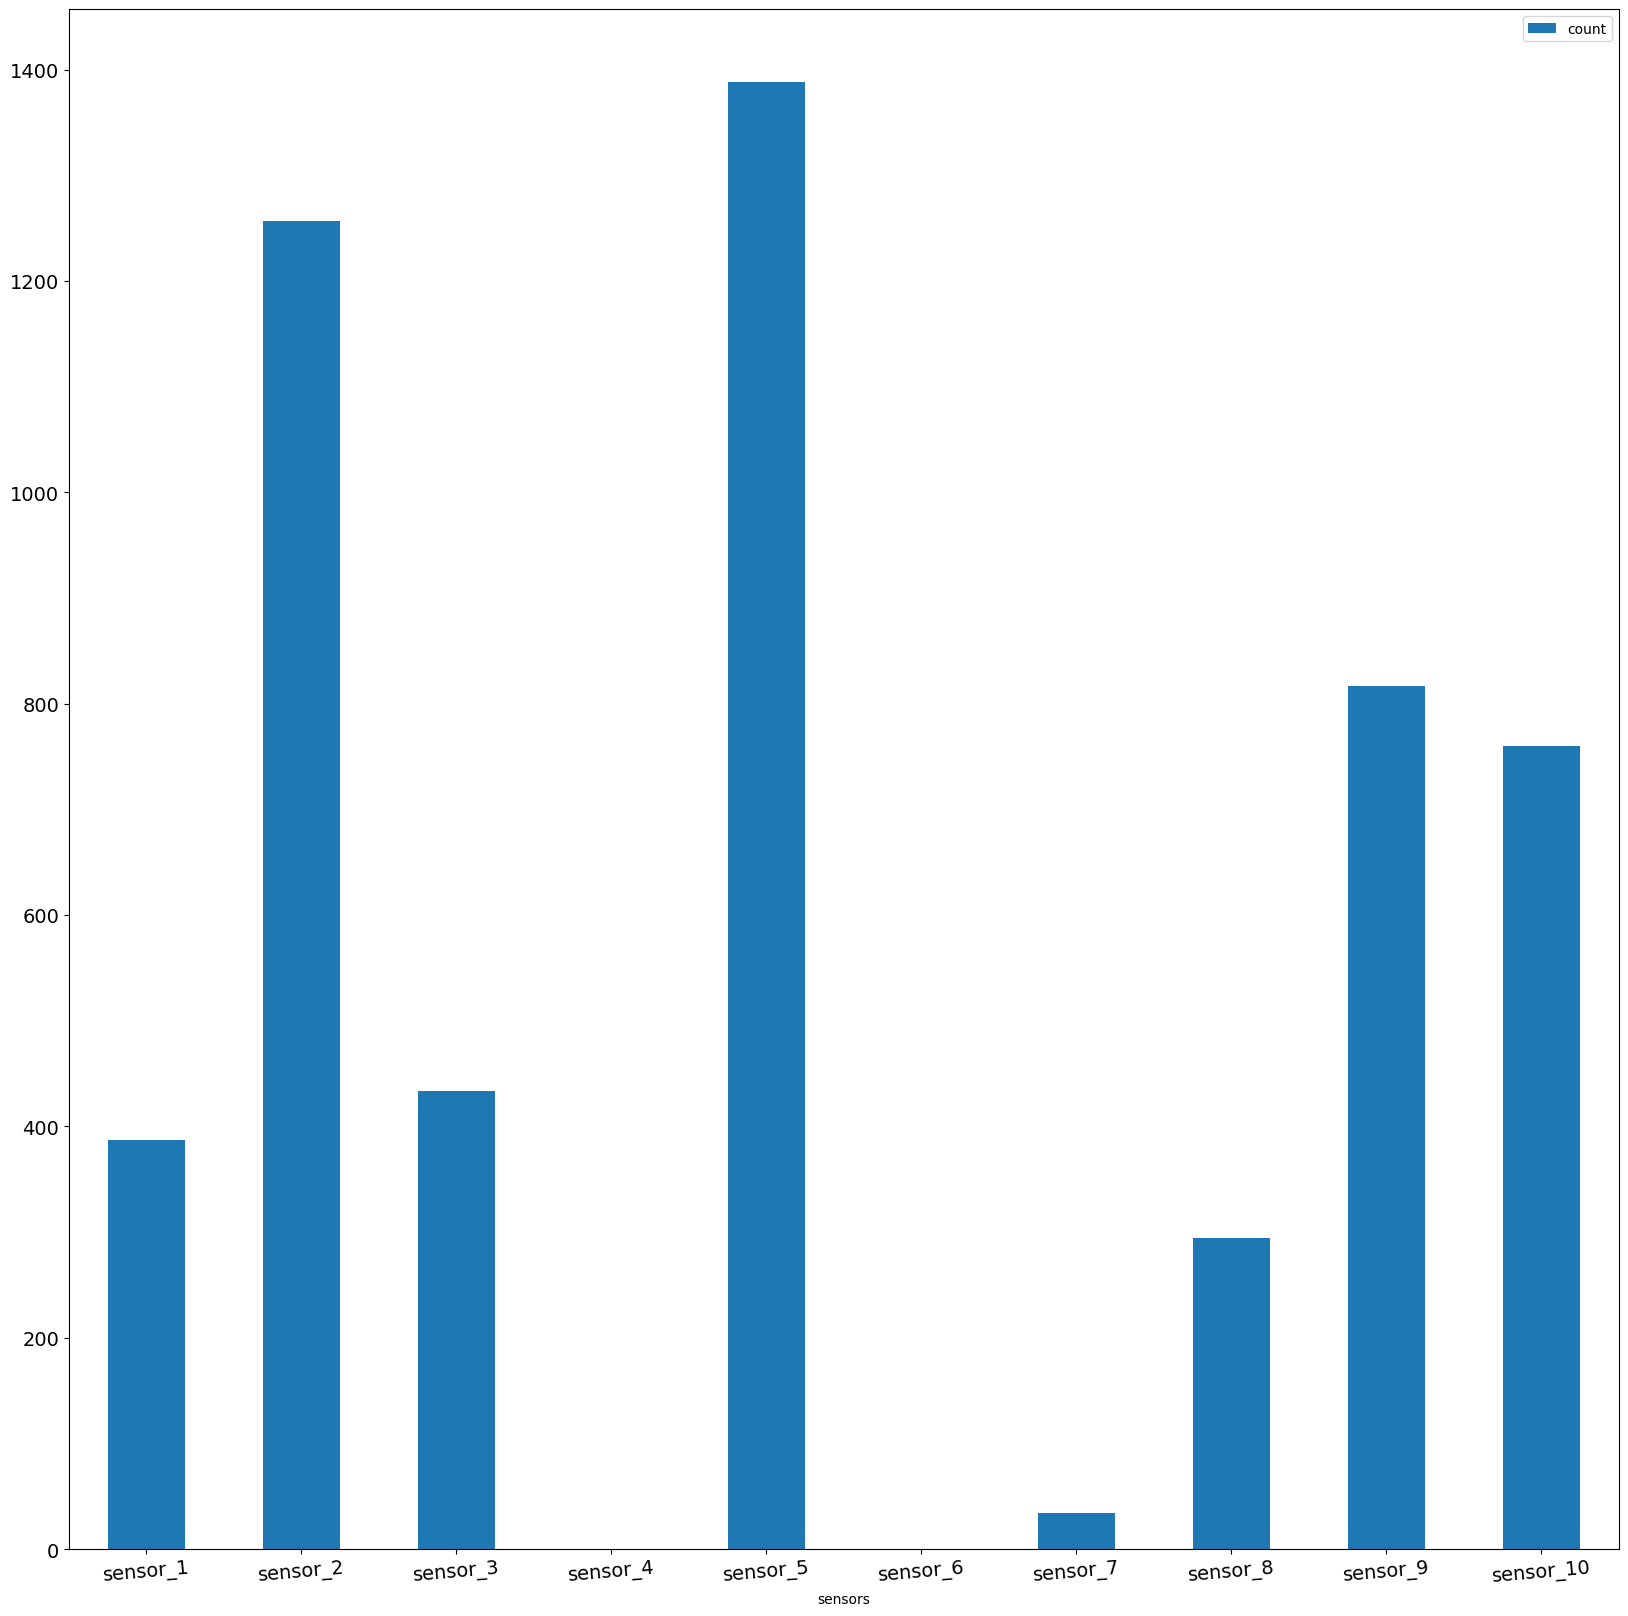

In [ ]:
NaNDF.plot(figsize =(20, 20), x="sensors", y="count", kind="bar",  rot=5, fontsize=14 )

#Сборка датасета

это решение состоит в том, что из маленьких датасетов мы выделяем различные признаки и записываем это в один датасет

лучшая модель ExtraTreesRegressor

In [ ]:
dataMask = ["sum", "mean", "std", "max", "min", "skew", "quantile99", "quantile90", "quantile70",  "quantile20", "quantile10"]

In [ ]:
metaDataDict = {}
for column in pd.read_csv(file_list_train[1]).keys():
    for mask in dataMask:
        metaDataDict[f"{column}_{mask}"] = []


In [ ]:
for file in tqdm.tqdm(time_file["segment_id"]):
    data = pd.read_csv(f"/content/train/{file}.csv")
    for column in data.keys():
        if np.isnan(data[column]).any():
            metaDataDict[f"{column}_sum"].append(0)
            metaDataDict[f"{column}_mean"].append(0)
            metaDataDict[f"{column}_std"].append(0)
            metaDataDict[f"{column}_max"].append(0)
            metaDataDict[f"{column}_min"].append(0)
            metaDataDict[f"{column}_skew"].append(0)
            metaDataDict[f"{column}_quantile99"].append(0)
            metaDataDict[f"{column}_quantile90"].append(0)
            metaDataDict[f"{column}_quantile70"].append(0)
            metaDataDict[f"{column}_quantile20"].append(0)
            metaDataDict[f"{column}_quantile10"].append(0)
        else:
            metaDataDict[f"{column}_sum"].append(data[column].sum()) #сумма
            metaDataDict[f"{column}_mean"].append(data[column].mean()) # среднее
            metaDataDict[f"{column}_std"].append(data[column].std()) # стандартное отклонение
            metaDataDict[f"{column}_max"].append(data[column].max()) # максимум
            metaDataDict[f"{column}_min"].append(data[column].min()) # минимум
            metaDataDict[f"{column}_skew"].append(data[column].skew()) # коэффициент асимметрии
            metaDataDict[f"{column}_quantile99"].append(np.quantile(data[column], 0.99)) #99% значений находятся ниже этого значения.
            metaDataDict[f"{column}_quantile90"].append(np.quantile(data[column], 0.90))
            metaDataDict[f"{column}_quantile70"].append(np.quantile(data[column], 0.70))
            metaDataDict[f"{column}_quantile20"].append(np.quantile(data[column], 0.20))
            metaDataDict[f"{column}_quantile10"].append(np.quantile(data[column], 0.10))

100%|██████████| 4431/4431 [14:42<00:00,  5.02it/s]


In [ ]:
gc.collect()

30

In [ ]:
for key in metaDataDict.keys():
    time_file[key] = metaDataDict[key]

<ipython-input-14-f2d79d01b0e8>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  time_file[key] = metaDataDict[key]
<ipython-input-14-f2d79d01b0e8>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  time_file[key] = metaDataDict[key]
<ipython-input-14-f2d79d01b0e8>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = fram

In [ ]:
time_file = time_file.drop("segment_id", axis=1)

In [ ]:
df_tr=time_file

# Анализ полученного датасета

<Axes: >

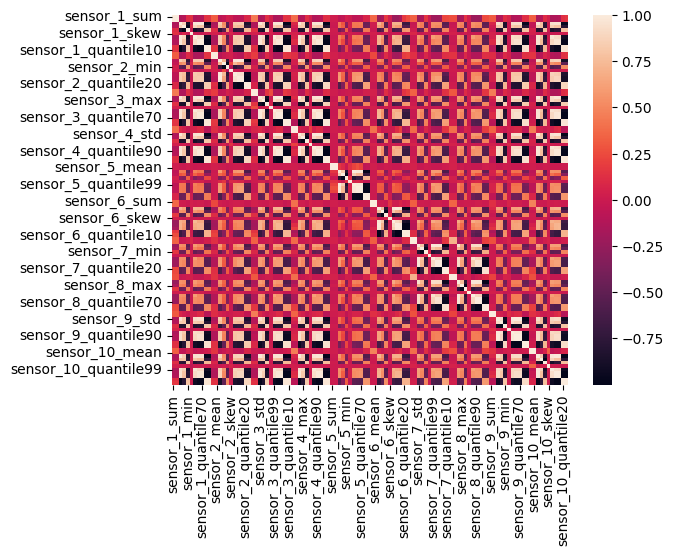

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix=time_file.drop("time_to_eruption", axis=1).corr()
sns.heatmap(corr_matrix)

In [ ]:
mask = (corr_matrix > 0.98)
mask.values[range(len(mask)), range(len(mask))] = False

high_corr_columns = mask.any(axis=0)
result_columns = corr_matrix.columns[high_corr_columns]

len(result_columns)

73

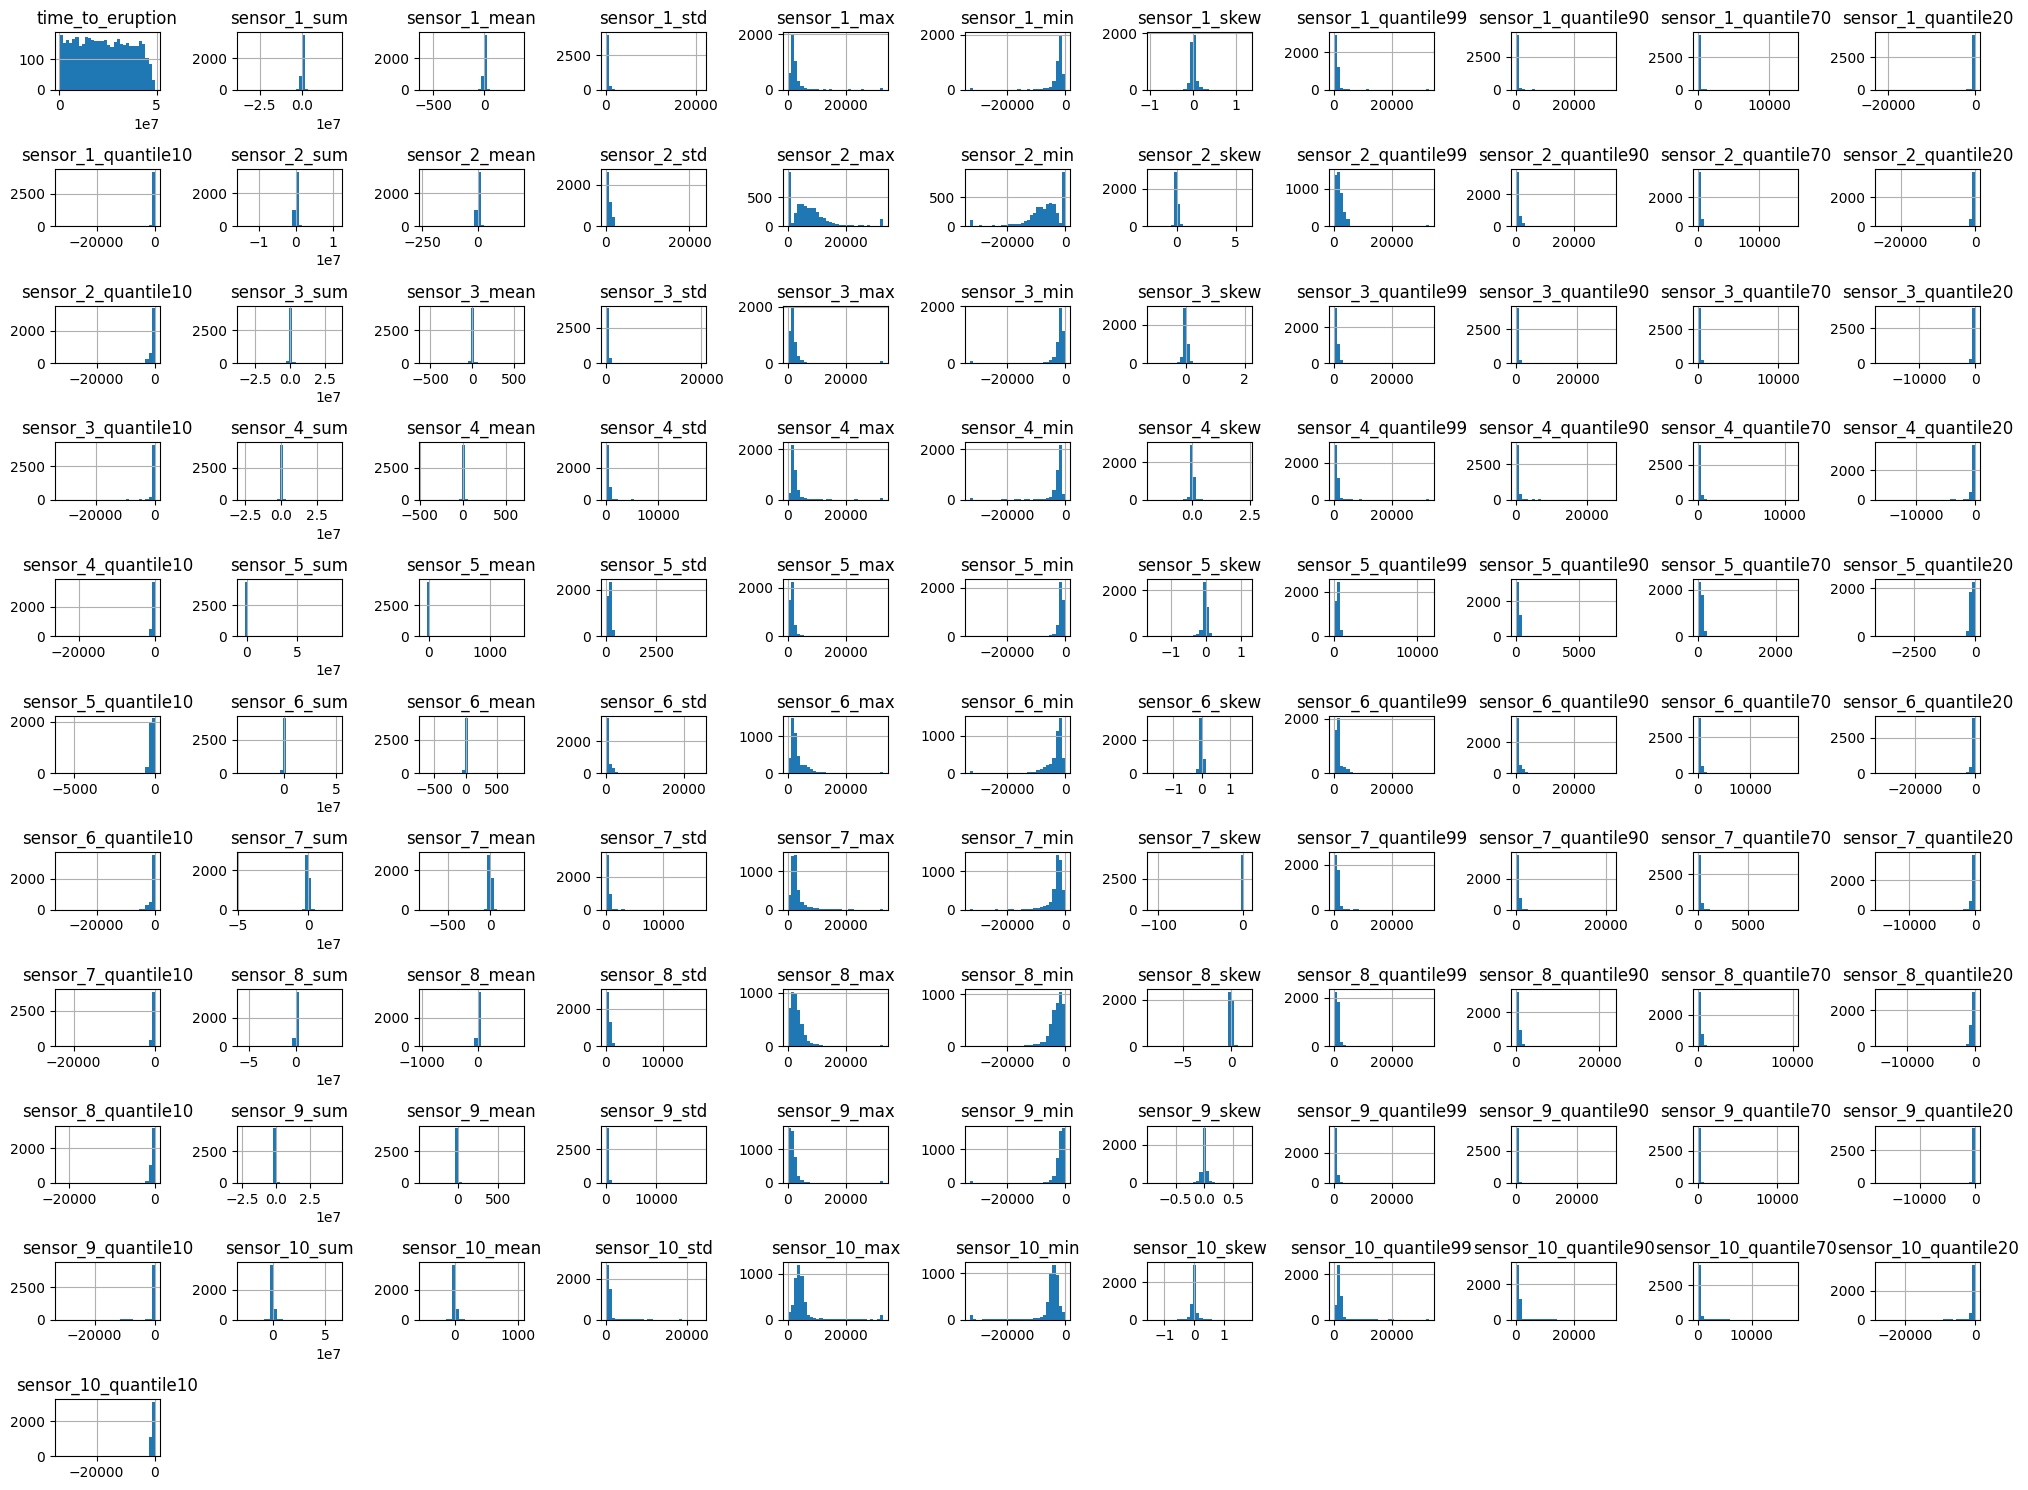

In [ ]:
time_file.hist(bins=30, figsize=(20, 15))
plt.tight_layout()
plt.show()


In [ ]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [ ]:
gc.collect()

0

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

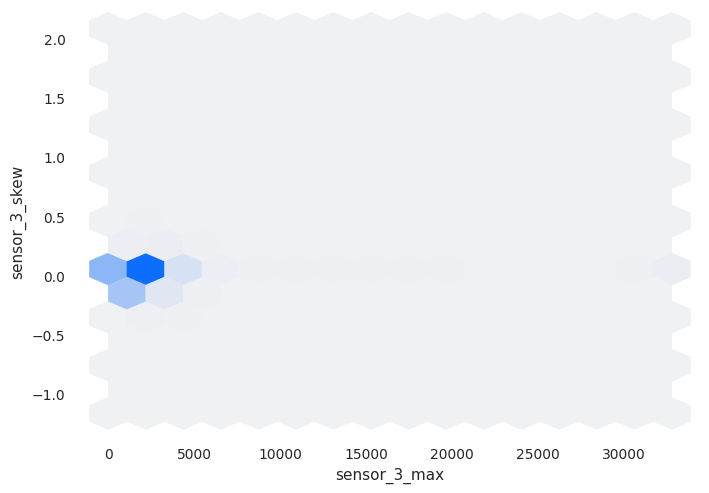

In [ ]:
from pandas_profiling import ProfileReport


# Создание профиля
profile = ProfileReport(df_tr, title="Pandas Profiling Report", explorative=True)

# Сохранение отчета в HTML файл
#profile.to_file("pandas_profiling_report.html")

# Если вы хотите отобразить отчет в Jupyter Notebook, используйте:
profile.to_notebook_iframe()


Mean Absolute Error: 3558208.97


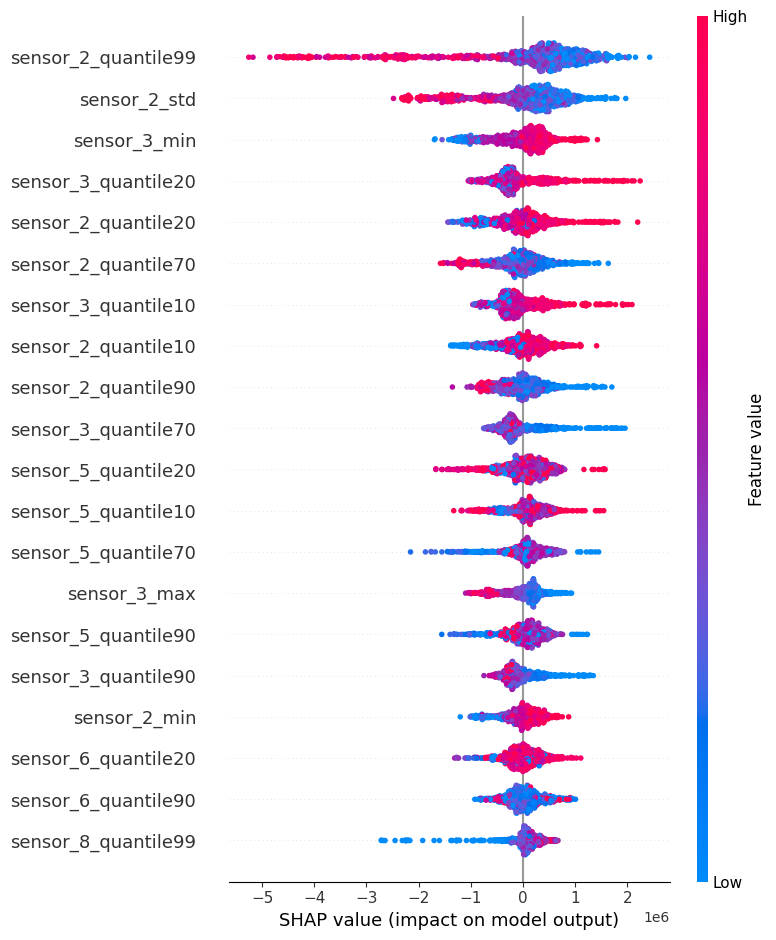

In [ ]:
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error

X = df_tr.drop('time_to_eruption', axis=1)
y = df_tr['time_to_eruption']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = ExtraTreesRegressor(max_depth=30)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae:.2f}')


explainer = shap.Explainer(model)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)


# попытка снизить размерность
(провал)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression


X = time_file.drop(columns=['time_to_eruption'])
y = time_file['time_to_eruption']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 1. Фильтрационный метод: Выбор лучших признаков с помощью SelectKBest
print("Выбор лучших признаков с помощью SelectKBest:")
selector = SelectKBest(score_func=f_regression, k=10)  # Выбираем 2 лучших признака
X_new = selector.fit_transform(X_train, y_train)
selected_features = X.columns[selector.get_support()].tolist()
print("Выбранные признаки:", selected_features)

# 2. Обертка: Рекурсивное исключение признаков (RFE)
print("\nРекурсивное исключение признаков (RFE):")
model = LinearRegression()  # Используем линейную регрессию
rfe = RFE(model, n_features_to_select=10)
fit = rfe.fit(X_train, y_train)
selected_features=X.columns[fit.support_].tolist()
print("Выбранные признаки:", X.columns[fit.support_].tolist())

# 3. Встраиваемый метод: Важность признаков с помощью случайного леса
print("\nВажность признаков с помощью случайного леса:")
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
importances = rf_model.feature_importances_
indices = sorted(range(len(importances)), key=lambda i: importances[i], reverse=True)

print("Важность признаков:")
for i in indices:
    print(f"{X.columns[i]}: {importances[i]:.4f}")


Выбор лучших признаков с помощью SelectKBest:
Выбранные признаки: ['sensor_2_std', 'sensor_2_max', 'sensor_2_min', 'sensor_2_quantile99', 'sensor_2_quantile90', 'sensor_2_quantile70', 'sensor_2_quantile20', 'sensor_2_quantile10', 'sensor_3_max', 'sensor_3_min']

Рекурсивное исключение признаков (RFE):
Выбранные признаки: ['sensor_1_skew', 'sensor_2_skew', 'sensor_3_skew', 'sensor_4_skew', 'sensor_5_skew', 'sensor_6_skew', 'sensor_7_skew', 'sensor_8_skew', 'sensor_9_skew', 'sensor_10_skew']

Важность признаков с помощью случайного леса:
Важность признаков:
sensor_2_quantile99: 0.1536
sensor_3_max: 0.0332
sensor_3_min: 0.0308
sensor_5_quantile99: 0.0300
sensor_6_quantile70: 0.0259
sensor_2_std: 0.0226
sensor_5_quantile70: 0.0224
sensor_1_quantile20: 0.0219
sensor_9_quantile99: 0.0208
sensor_1_quantile70: 0.0196
sensor_6_quantile99: 0.0164
sensor_6_quantile90: 0.0159
sensor_6_quantile10: 0.0154
sensor_8_quantile99: 0.0132
sensor_10_quantile20: 0.0130
sensor_2_quantile70: 0.0125
sensor_1_m

# PCA
(улучшений не дало)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

X = df_tr.drop(columns=['time_to_eruption'])
y = df_tr['time_to_eruption']

xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=42)

pca = PCA(n_components=60)
xTrain = pca.fit_transform(xTrain)
xTest = pca.transform(xTest)




# Стандартизация и нормализация

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X = df_tr.drop("time_to_eruption", axis=1).copy()

стандартизация

In [ ]:
scaler_standard = StandardScaler()
X_standardized = scaler_standard.fit_transform(X)

df_standardized = pd.DataFrame(X_standardized, columns=X.columns)


нормализация

In [ ]:
scaler_minmax = MinMaxScaler()
X_normalized = scaler_minmax.fit_transform(X)


df_normalized = pd.DataFrame(X_normalized, columns=X.columns)

# Решения

In [ ]:
time_file.isna().sum().sum()

0

In [ ]:
time_file

,time_to_eruption,sensor_1_sum,sensor_1_mean,sensor_1_std,sensor_1_max,sensor_1_min,sensor_1_skew,sensor_1_quantile99,sensor_1_quantile90,sensor_1_quantile70,...,sensor_10_std,sensor_10_max,sensor_10_min,sensor_10_skew,sensor_10_quantile99,sensor_10_quantile90,sensor_10_quantile70,sensor_10_quantile50,sensor_10_quantile20,sensor_10_quantile10
0,12262005,-96621.0,-1.610323,303.096099,1353.0,-1421.0,-0.057494,704.0,383.0,153.0,...,596.865818,2187.0,-3527.0,-0.048443,1375.0,767.0,324.0,0.0,-503.0,-757.0
1,32739612,85569.0,1.426126,438.360560,2197.0,-2005.0,-0.001189,1108.0,528.0,209.0,...,932.699662,5319.0,-4591.0,0.202520,2494.0,1146.0,439.0,0.0,-692.0,-1091.0
2,14965999,150278.0,2.504592,241.575415,1148.0,-1115.0,0.071632,613.0,307.0,121.0,...,500.544892,2522.0,-2798.0,0.007192,1231.0,624.0,249.0,0.0,-402.0,-618.0
3,26469720,129950.0,2.165797,221.967825,1254.0,-1025.0,0.123639,556.0,273.0,108.0,...,523.449843,3614.0,-2911.0,0.229183,1339.0,652.0,254.0,0.0,-400.0,-625.0
4,31072429,4429.0,0.073815,261.695935,1114.0,-1190.0,0.006594,636.0,329.0,132.0,...,562.748316,3274.0,-2611.0,-0.014160,1334.0,698.0,280.0,0.0,-458.0,-715.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4426,15695097,54405.0,0.906735,613.427301,2916.0,-2610.0,-0.003413,1433.0,782.0,322.0,...,1053.539787,5493.0,-5726.0,-0.001635,2580.0,1305.0,512.0,0.0,-839.0,-1338.0
4427,35659379,476221.0,7.936884,649.089618,4498.0,-3654.0,0.113867,1565.0,827.0,329.0,...,1279.909391,14873.0,-13017.0,0.108147,3079.0,1536.0,611.0,0.0,-976.0,-1480.0
4428,31206935,85261.0,1.420993,110.942596,557.0,-753.0,-0.060527,270.0,140.0,56.0,...,251.560198,1549.0,-1708.0,-0.072757,637.0,291.0,115.0,0.0,-187.0,-293.0
4429,9598270,54350.0,0.905818,478.852581,3938.0,-3555.0,0.028062,1237.0,566.0,216.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
x = time_file.drop("time_to_eruption", axis=1)
y = time_file["time_to_eruption"]

xTrain, xTest, yTrain, yTest = train_test_split(x, y, train_size=0.8)

# Эксперименты с данными

In [ ]:
experiment=time_file

In [ ]:
experiment

In [ ]:
dataMask_ = ["sum", "mean", "std", "max", "min", "skew", "quantile99",  "quantile90","quantile70", "quantile50",  "quantile10"]

In [ ]:
metaDataDict_ = {}
for column in pd.read_csv(file_list_train[1]).keys():
    for mask in dataMask_:
        metaDataDict_[f"{column}_{mask}"] = []
metaDataDict_

In [ ]:
for file in tqdm.tqdm(experiment["segment_id"]):
    data = pd.read_csv(f"/content/train/{file}.csv")
    for column in data.keys():
        if np.isnan(data[column]).any():
            metaDataDict_[f"{column}_sum"].append(0)
            metaDataDict_[f"{column}_mean"].append(0)
            metaDataDict_[f"{column}_std"].append(0)
            metaDataDict_[f"{column}_max"].append(0)
            metaDataDict_[f"{column}_min"].append(0)
            metaDataDict_[f"{column}_skew"].append(0)
            metaDataDict_[f"{column}_quantile99"].append(0)
            metaDataDict_[f"{column}_quantile90"].append(0)
            metaDataDict_[f"{column}_quantile70"].append(0)
            metaDataDict_[f"{column}_quantile50"].append(0)
            metaDataDict_[f"{column}_quantile20"].append(0)
            metaDataDict_[f"{column}_quantile10"].append(0)
            metaDataDict[f"{column}_median"].append(0)
        else:
            metaDataDict_[f"{column}_sum"].append(data[column].sum()) #сумма
            metaDataDict_[f"{column}_mean"].append(data[column].mean()) # среднее
            metaDataDict_[f"{column}_std"].append(data[column].std()) # стандартное отклонение
            metaDataDict_[f"{column}_max"].append(data[column].max()) # максимум
            metaDataDict_[f"{column}_min"].append(data[column].min()) # минимум
            metaDataDict_[f"{column}_skew"].append(data[column].skew()) # коэффициент асимметрии
            metaDataDict[f"{column}_median"].append(data[column].median())
            metaDataDict_[f"{column}_quantile99"].append(np.quantile(data[column], 0.99)) #99% значений находятся ниже этого значения.
            metaDataDict_[f"{column}_quantile90"].append(np.quantile(data[column], 0.90))
            metaDataDict_[f"{column}_quantile70"].append(np.quantile(data[column], 0.70))
            metaDataDict_[f"{column}_quantile50"].append(np.quantile(data[column], 0.50))
            metaDataDict_[f"{column}_quantile20"].append(np.quantile(data[column], 0.20))
            metaDataDict_[f"{column}_quantile10"].append(np.quantile(data[column], 0.10))

100%|██████████| 4431/4431 [12:26<00:00,  5.94it/s]


In [ ]:
for key in metaDataDict_.keys():
    experiment[key] = metaDataDict_[key]

<ipython-input-40-690cab3a455b>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  experiment[key] = metaDataDict_[key]


In [ ]:
experiment = experiment.drop("segment_id", axis=1)

In [ ]:
experiment

In [ ]:
x = df_normalized#.drop("time_to_eruption", axis=1)
y = time_file["time_to_eruption"]

xTrain, xTest, yTrain, yTest = train_test_split(x, y, train_size=0.8)

In [ ]:
gc.collect()

28

# модели

ExtraTreesRegressor - best

mae 0.2633346488679097

r2 0.8530602222269934

In [ ]:
model_ETR = ExtraTreesRegressor(max_depth=30)
model_ETR.fit(xTrain, yTrain)
yPred = model_ETR.predict(xTest)


In [ ]:
print(mean_absolute_error(yTest, yPred))
r2_score(yTest, yPred)

3545847.57250821


0.8355104723477691

logistic regression

In [ ]:
model_LR= linear_model.LogisticRegression()
model_LR.fit(xTrain, yTrain)
yPred = model_LR.predict(xTest)

In [ ]:
print(mean_absolute_error(yTest, yPred))
r2_score(yTest, yPred)

12080852.01352875


-0.35915477439585963

ElasticNet


In [ ]:
model_EN = ElasticNetCV()
model_EN.fit(xTrain, yTrain)
yPred = model_EN.predict(xTest)

In [ ]:
print(mean_absolute_error(yTest, yPred))
r2_score(yTest, yPred)

11398045.722733404


-0.0017142872499440465

gradient boosting

In [ ]:
params = {
    "n_estimators": 1500,#попробовать больше
    "max_depth": 8,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

model_grad = ensemble.GradientBoostingRegressor(**params)
model_grad.fit(xTrain, yTrain)
yPred = model_grad.predict(xTest)

In [ ]:
print(mean_absolute_error(yTest, yPred))
r2_score(yTest, yPred)

3993379.6845988263


0.8067966825863102

linear regression

In [ ]:
model_lin = LinearRegression()

model_lin.fit(xTrain, yTrain)

yPred = model_lin.predict(xTest)

In [ ]:
print(mean_absolute_error(yTest, yPred))
r2_score(yTest, yPred)


10396493.259430218


-0.15637414549420048

освобождение озу

In [ ]:
gc.collect()

7763

нейронка

In [ ]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()

model.add(Dense(128, activation='relu', input_shape=(xTrain.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='relu'))


optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
history = model.fit(xTrain, yTrain, epochs=160, validation_split=0.1, verbose=2, batch_size=64)

In [ ]:
!pip install tensorflow scikeras scikit-learn

In [ ]:
#прогрузить
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from scikeras.wrappers import KerasRegressor  # Новая обёртка для Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

def create_model(learning_rate=0.01, activation='relu'):
    model = Sequential()
    model.add(Dense(128, activation=activation, input_shape=(xTrain.shape[1],)))
    model.add(Dense(64, activation=activation))
    model.add(Dense(32, activation=activation))
    model.add(Dense(1, activation='relu'))

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])
    return model

model = KerasRegressor(model=create_model, verbose=0)

param_grid = {
    'batch_size': [32, 64, 128],
    'model__learning_rate': [0.01, 0.001, 0.0001],
    'model__activation': ['relu', 'tanh'],
    'epochs': [100, 160]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3)
grid_result = grid.fit(xTrain, yTrain)

print(f"Лучший результат: {grid_result.best_score_} с параметрами: {grid_result.best_params_}")
#56 мин

Epoch 1/100
25/25 - 2s - 69ms/step - loss: 22629440.0000 - mae: 22629440.0000 - val_loss: 21917170.0000 - val_mae: 21917170.0000
Epoch 2/100
25/25 - 0s - 7ms/step - loss: 20165020.0000 - mae: 20165020.0000 - val_loss: 21218146.0000 - val_mae: 21218146.0000
Epoch 3/100
25/25 - 0s - 12ms/step - loss: 19027142.0000 - mae: 19027142.0000 - val_loss: 20698242.0000 - val_mae: 20698242.0000
Epoch 4/100
25/25 - 0s - 11ms/step - loss: 17959440.0000 - mae: 17959440.0000 - val_loss: 19981112.0000 - val_mae: 19981112.0000
Epoch 5/100
25/25 - 0s - 8ms/step - loss: 16983586.0000 - mae: 16983586.0000 - val_loss: 19449406.0000 - val_mae: 19449406.0000
Epoch 6/100
25/25 - 0s - 11ms/step - loss: 15698039.0000 - mae: 15698039.0000 - val_loss: 17674500.0000 - val_mae: 17674500.0000
Epoch 7/100
25/25 - 0s - 14ms/step - loss: 14840225.0000 - mae: 14840225.0000 - val_loss: 16264962.0000 - val_mae: 16264962.0000
Epoch 8/100
25/25 - 0s - 9ms/step - loss: 14339390.0000 - mae: 14339390.0000 - val_loss: 15282153.0

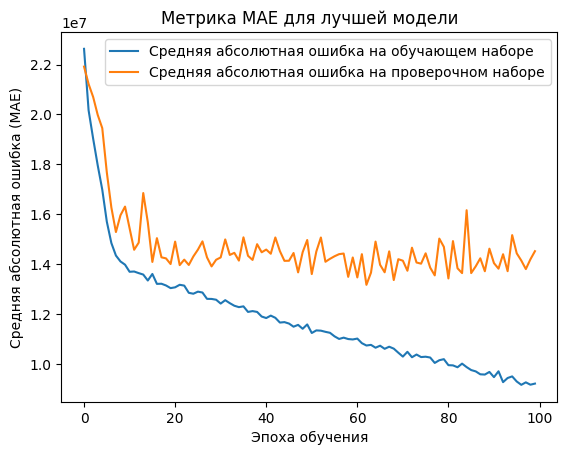

In [ ]:

best_params = grid_result.best_params_
best_model = create_model(learning_rate=best_params['model__learning_rate'],
                          activation=best_params['model__activation'])

history = best_model.fit(
    xTrain, yTrain,
    validation_split=0.1,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=2
)

plt.plot(history.history['mae'], label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка (MAE)')
plt.title('Метрика MAE для лучшей модели')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['mae'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [ ]:
yPred = best_model.predict(xTest)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [ ]:
print(mean_absolute_error(yTest, yPred))
r2_score(yTest, yPred)

13762521.34673883


-2.4891841411590576

# Submition

In [ ]:
metaDataDict2 = {}
for column in pd.read_csv(file_list_test[1]).keys():
    for mask in dataMask:
        metaDataDict2[f"{column}_{mask}"] = []

In [ ]:
segment_ids = [file.split("/")[3][:-4] for file in file_list_test]
time_file1 = pd.DataFrame({'segment_id': segment_ids})

In [ ]:
for file in tqdm.tqdm(time_file1["segment_id"]):
    data = pd.read_csv(f"/content/test/{file}.csv")
    for column in data.keys():
        if np.isnan(data[column]).any():
            metaDataDict2[f"{column}_sum"].append(0)
            metaDataDict2[f"{column}_mean"].append(0)
            metaDataDict2[f"{column}_std"].append(0)
            metaDataDict2[f"{column}_max"].append(0)
            metaDataDict2[f"{column}_min"].append(0)
            metaDataDict2[f"{column}_skew"].append(0)
            metaDataDict2[f"{column}_quantile99"].append(0)
            metaDataDict2[f"{column}_quantile90"].append(0)
            metaDataDict2[f"{column}_quantile70"].append(0)
            metaDataDict2[f"{column}_quantile20"].append(0)
            metaDataDict2[f"{column}_quantile10"].append(0)

        else:
            metaDataDict2[f"{column}_sum"].append(data[column].sum()) #сумма
            metaDataDict2[f"{column}_mean"].append(data[column].mean()) # среднее
            metaDataDict2[f"{column}_std"].append(data[column].std()) # стандартное отклонение
            metaDataDict2[f"{column}_max"].append(data[column].max()) # максимум
            metaDataDict2[f"{column}_min"].append(data[column].min()) # минимум
            metaDataDict2[f"{column}_skew"].append(data[column].skew()) # коэффициент асимметрии
            metaDataDict2[f"{column}_quantile99"].append(np.quantile(data[column], 0.99)) #99% значений находятся ниже этого значения.
            metaDataDict2[f"{column}_quantile90"].append(np.quantile(data[column], 0.90))
            metaDataDict2[f"{column}_quantile70"].append(np.quantile(data[column], 0.70))
            metaDataDict2[f"{column}_quantile20"].append(np.quantile(data[column], 0.20))
            metaDataDict2[f"{column}_quantile10"].append(np.quantile(data[column], 0.10))

100%|██████████| 4520/4520 [11:50<00:00,  6.36it/s]


In [ ]:
for key in metaDataDict2.keys():
    time_file1[key] = metaDataDict2[key]

In [ ]:
time_file1

,sensor_1_sum,sensor_1_mean,sensor_1_std,sensor_1_max,sensor_1_min,sensor_1_skew,sensor_1_quantile99,sensor_1_quantile90,sensor_1_quantile70,sensor_1_quantile20,...,sensor_10_mean,sensor_10_std,sensor_10_max,sensor_10_min,sensor_10_skew,sensor_10_quantile99,sensor_10_quantile90,sensor_10_quantile70,sensor_10_quantile20,sensor_10_quantile10
0,-126763.0,-2.112681,381.496363,1554.0,-1516.0,-0.014246,885.0,493.0,195.0,-325.0,...,6.183080,691.228652,3273.0,-2674.0,0.051749,1664.0,889.0,359.0,-572.0,-863.0
1,-21610.0,-0.360161,587.347090,2828.0,-3118.0,-0.039061,1382.0,735.0,302.0,-474.0,...,-12.159097,1101.595416,4651.0,-4954.0,-0.043790,2603.0,1370.0,549.0,-917.0,-1405.0
2,30408.0,0.506792,227.067808,1594.0,-1870.0,-0.032126,563.0,277.0,109.0,-177.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,537069.0,8.951001,391.110847,1674.0,-1473.0,0.093477,974.0,514.0,199.0,-312.0,...,-4.538641,669.705550,3590.0,-3613.0,-0.014075,1610.0,827.0,346.0,-554.0,-853.0
4,263495.0,4.391510,436.408361,2473.0,-3038.0,-0.034343,1039.0,540.0,225.0,-348.0,...,4.240763,774.412442,4951.0,-4963.0,0.042046,1886.0,958.0,389.0,-618.0,-948.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4515,-183892.0,-3.064816,346.443772,1548.0,-1926.0,0.007164,838.0,424.0,171.0,-283.0,...,-4.235596,594.713771,3577.0,-3794.0,-0.107792,1460.0,710.0,282.0,-459.0,-721.0
4516,-32090.0,-0.534824,435.357213,2353.0,-2558.0,-0.047897,1100.0,519.0,206.0,-334.0,...,-3.347061,699.282206,3469.0,-3367.0,-0.054182,1724.0,848.0,340.0,-551.0,-858.0
4517,34013.0,0.566874,118.616264,654.0,-630.0,-0.027620,288.0,148.0,59.0,-95.0,...,-3.014033,238.782884,1541.0,-2016.0,-0.140578,650.0,259.0,99.0,-169.0,-270.0
4518,98057.0,1.634256,288.707968,1683.0,-2517.0,0.034931,716.0,358.0,146.0,-232.0,...,1.047266,689.943008,3290.0,-3199.0,0.011733,1679.0,866.0,341.0,-550.0,-864.0


In [ ]:
y = model_ETR.predict(time_file1.drop(["segment_id"], axis=1))

In [ ]:
submit=pd.DataFrame()
submit["segment_id"]=time_file1["segment_id"]
submit["time_to_eruption"] = y

In [ ]:
submit.to_csv("submit.csv", index=False)